In [1]:
import dask.diagnostics
import fsspec
import fv3fit
import pandas as pd
import proplot
import vcm
import vcm.catalog
import xarray as xr

import plotting
import times

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
plotting.configure_style()

In [3]:
TEST_DATA = "gs://vcm-ml-experiments/spencerc/2022-05-04/n2f-25km-tapered-25-snoalb-nudging-tendencies-and-fluxes.zarr"
MODELS = {
    0: "gs://vcm-ml-experiments/spencerc/2022-03-12-nudge-to-25-km-ml-models/tq-nn-snoalb-tapered-clipped-25-seed-0",
    1: "gs://vcm-ml-experiments/spencerc/2022-03-12-nudge-to-25-km-ml-models/tq-nn-snoalb-tapered-clipped-25-seed-1",
    2: "gs://vcm-ml-experiments/spencerc/2022-03-12-nudge-to-25-km-ml-models/tq-nn-snoalb-tapered-clipped-25-seed-2",
    3: "gs://vcm-ml-experiments/spencerc/2022-03-12-nudge-to-25-km-ml-models/tq-nn-snoalb-tapered-clipped-25-seed-3"
}
LOADED_MODELS = {k: fv3fit.load(v) for k, v in MODELS.items()}

In [4]:
TESTING_TIMES_FILE = "../workflows/ml-training/test.json"
testing_times = times.open_times(TESTING_TIMES_FILE)

In [5]:
def _predict_kernel(ds, model):
    return model.predict(ds).transpose(*ds.dims)


def predict(ds, model, template):
    """A dask-compatible version of model.predict"""
    template = template.transpose(*ds.dims)
    return xr.map_blocks(
        _predict_kernel,
        ds,
        args=(model,),
        template=template
    )


def interpolate(ds, delp):
    return vcm.interpolate_to_pressure_levels(ds, delp, dim="z")


def coefficient_of_determination(target, prediction, grid):
    error = prediction - target
    with dask.diagnostics.ProgressBar():
        mean = target.mean("time").weighted(grid.area).mean(["x", "y", "tile"]).compute()
        mean_square_error = (error ** 2).mean("time").weighted(grid.area).mean(["x", "y", "tile"]).compute()
        variance = ((target - mean) ** 2).mean("time").weighted(grid.area).mean(["x", "y", "tile"]).compute()
    return 1.0 - (mean_square_error / variance)


def coefficient_of_determination_all(target, prediction, grid):
    error = prediction - target
    with dask.diagnostics.ProgressBar():
        mean = target.mean("time").weighted(grid.area).mean(["x", "y", "tile"]).compute().mean("dataset")
        mean_square_error = (error ** 2).mean("time").weighted(grid.area).mean(["x", "y", "tile"]).compute().mean("dataset")
        variance = ((target - mean) ** 2).mean("time").weighted(grid.area).mean(["x", "y", "tile"]).compute().mean("dataset")
    return 1.0 - (mean_square_error / variance)

In [6]:
grid = vcm.catalog.catalog["grid/c48"].to_dask().load()
test_data = xr.open_zarr(fsspec.get_mapper(TEST_DATA)).sel(time=testing_times)
test_data = test_data.assign(cos_zenith_angle=vcm.cos_zenith_angle(test_data.time, grid.lon, grid.lat))

In [7]:
targets = test_data[["dQ1", "dQ2"]]

prediction_datasets = []
for seed, model in LOADED_MODELS.items():
    prediction_datasets.append(predict(test_data, model, targets))
predictions = xr.concat(prediction_datasets, dim=pd.Index(LOADED_MODELS.keys(), name="seed"))

In [8]:
interpolated_targets = interpolate(targets, test_data.pressure_thickness_of_atmospheric_layer)
interpolated_predictions = interpolate(predictions, test_data.pressure_thickness_of_atmospheric_layer)

In [9]:
per_climate_r2 = coefficient_of_determination(interpolated_targets, interpolated_predictions, grid)

[########                                ] | 21% Completed | 39.5s

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 45.2s
[#######                                 ] | 18% Completed |  3min 12.7s

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 28min  9.8s
[########                                ] | 20% Completed | 38.5s

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 15.1s


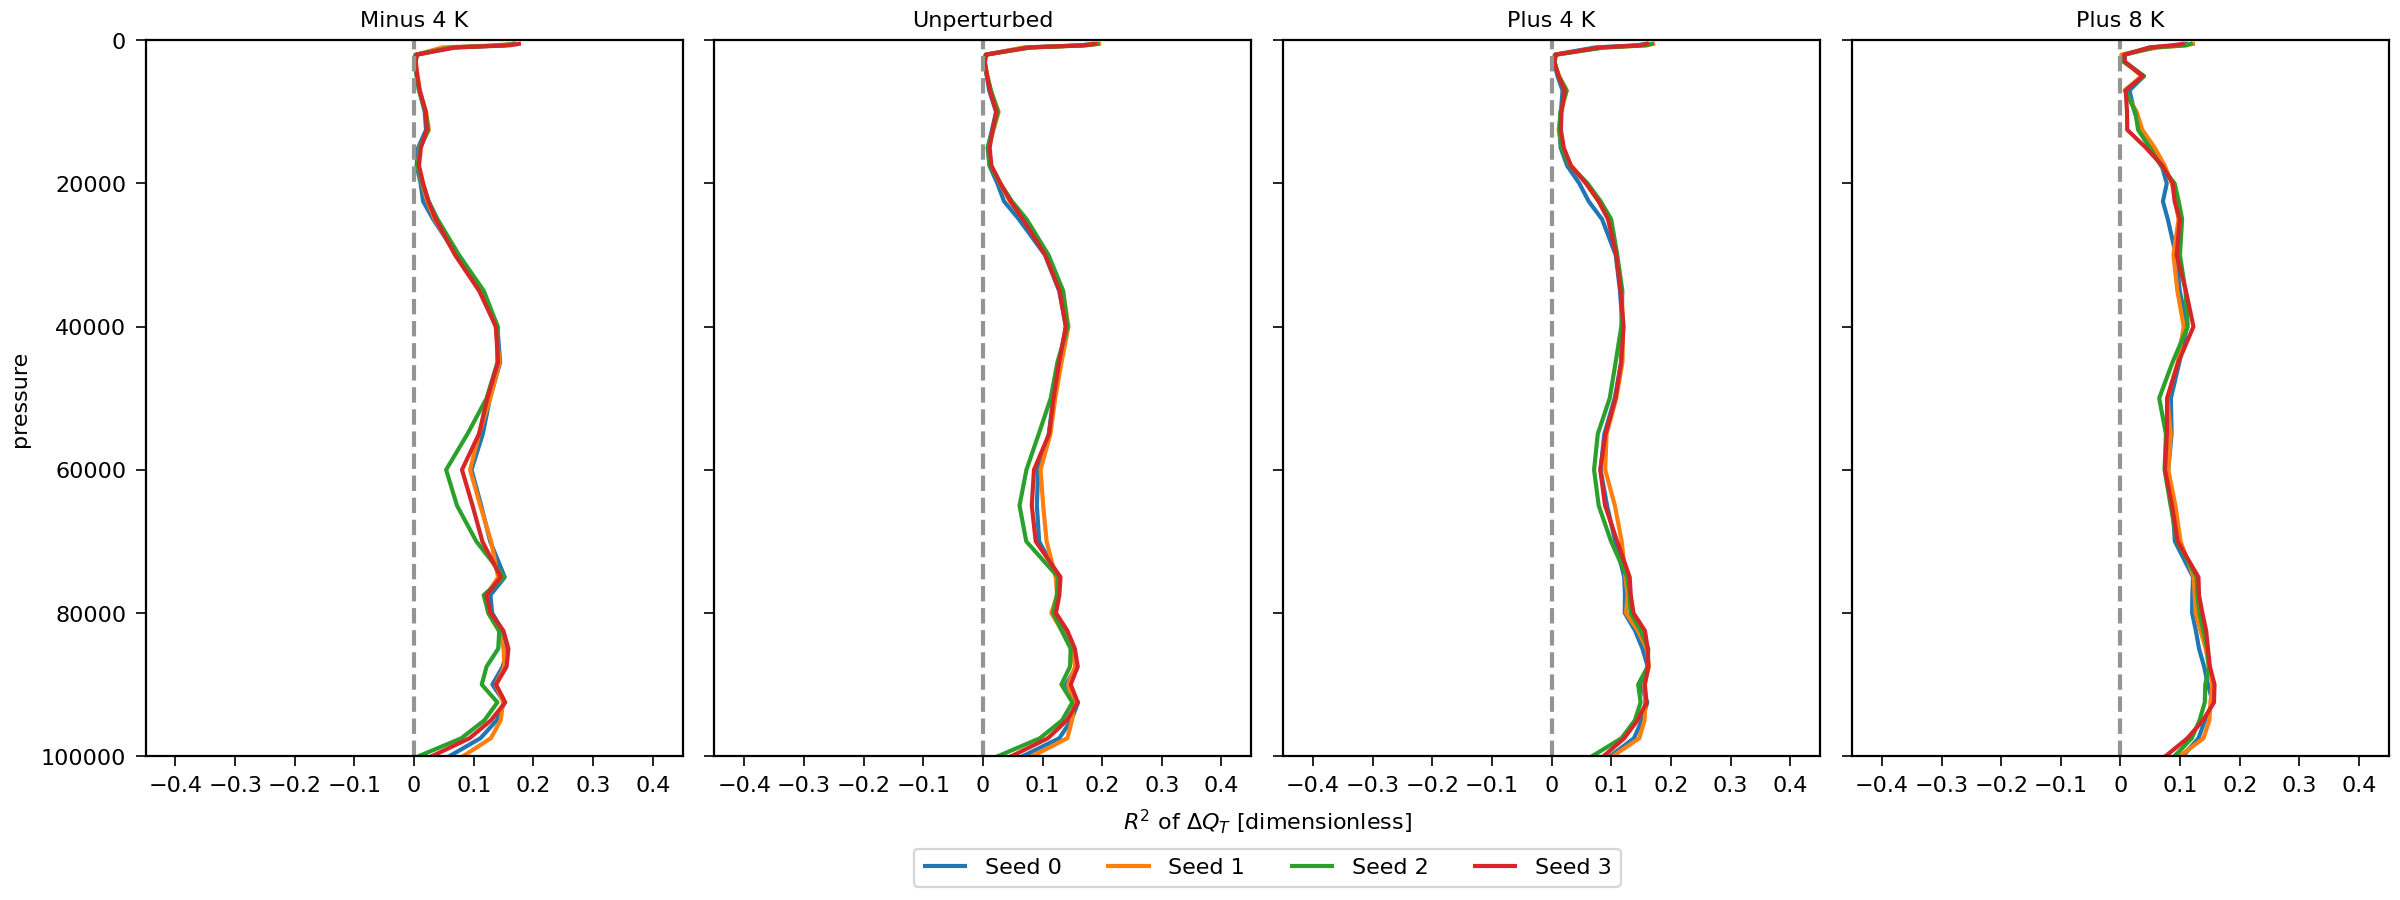

In [10]:
fig, axes = proplot.subplots(ncols=4, nrows=1, refaspect=0.75, figwidth=12)

labels = [f"Seed {i}" for i in range(4)]
for ax, dataset in zip(axes, per_climate_r2.dataset):
    handles = []
    for seed in per_climate_r2.seed:
        p = per_climate_r2.dQ1.sel(dataset=dataset, seed=seed).plot(ax=ax, y="pressure", yincrease=False, add_legend=False)
        handles.append(p)
    ax.set_xlim(-0.45, 0.45)
    ax.set_xticks([-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])
    ax.set_ylim(100000, 0)
    ax.axvline(0, color="gray", ls="--")
    ax.set_title(dataset.item())
    ax.set_xlabel("$R^2$ of $\Delta Q_T$ [dimensionless]")
    ax.set_label("Pressure [Pa]")
fig.legend(handles, labels, loc="bottom", ncols=len(labels))

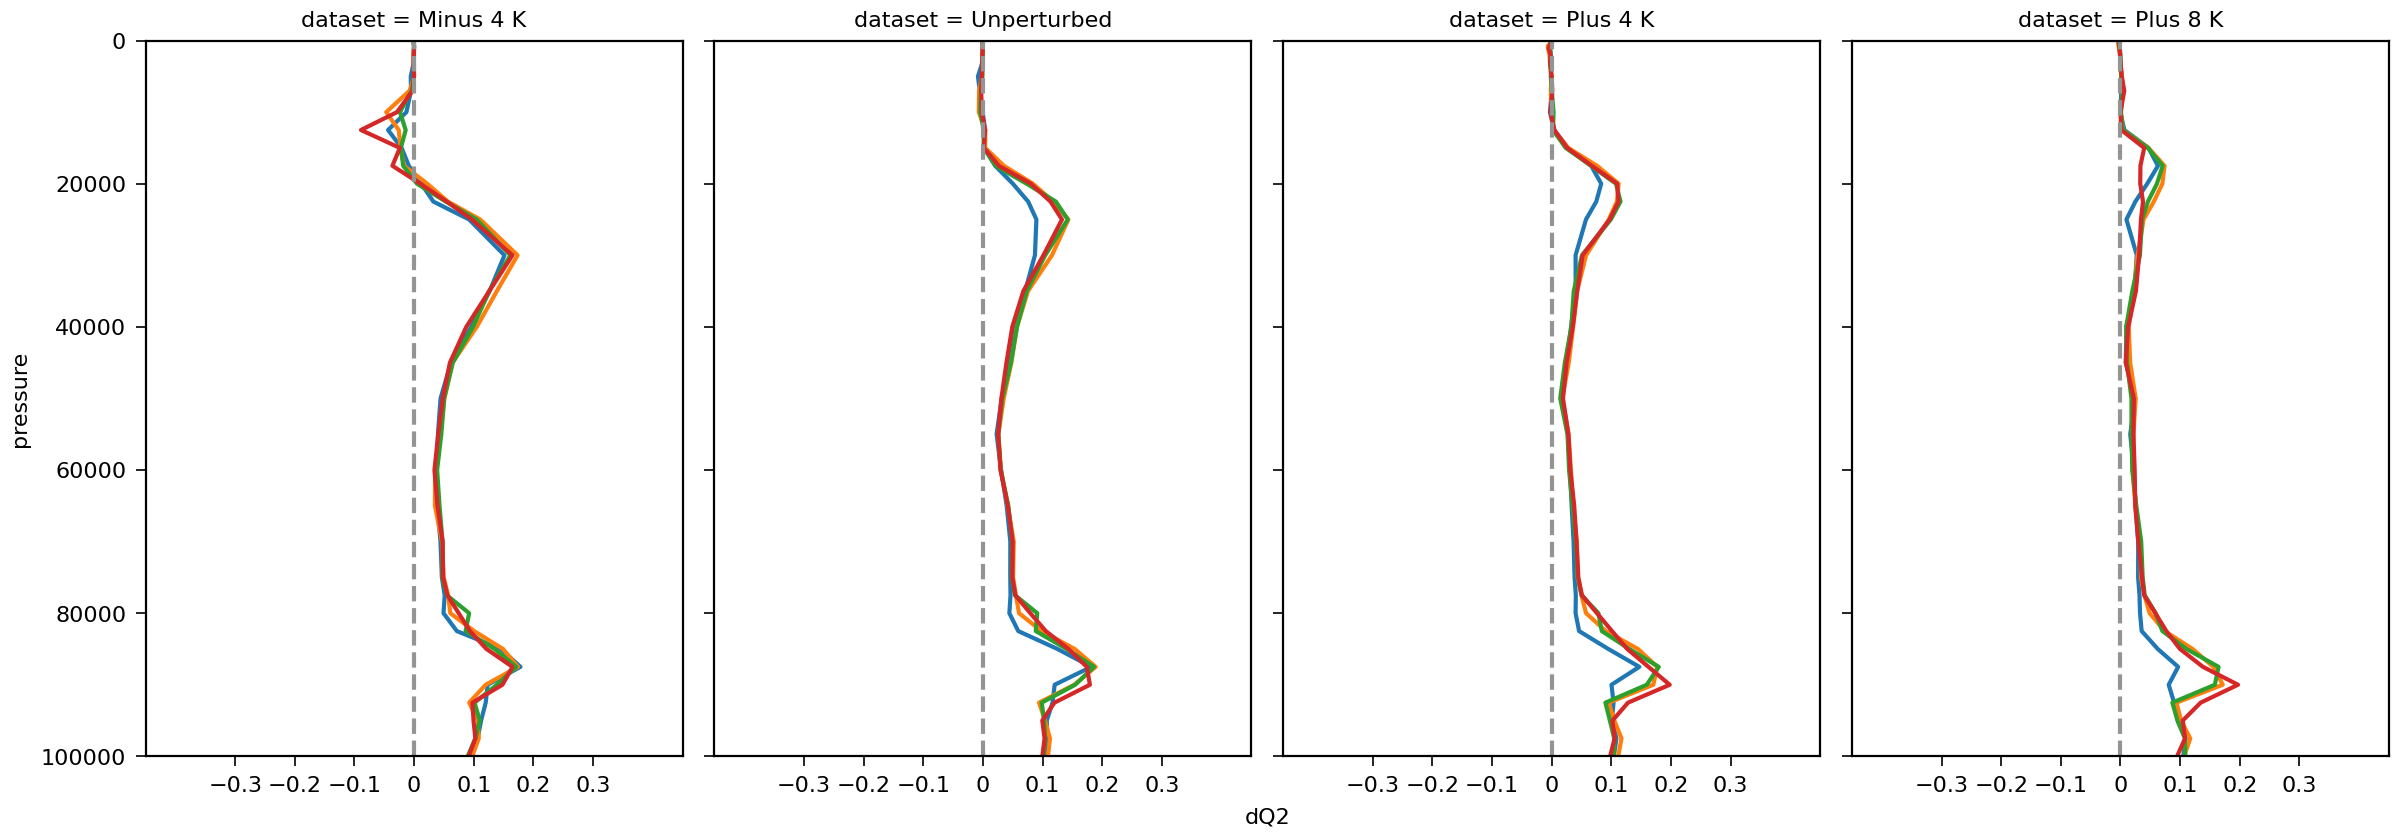

In [11]:
fig, axes = proplot.subplots(ncols=4, nrows=1, refaspect=0.75, figwidth=12)

for ax, dataset in zip(axes, per_climate_r2.dataset):
    per_climate_r2.dQ2.sel(dataset=dataset).plot(ax=ax, hue="seed", y="pressure", yincrease=False, add_legend=False)
    ax.set_xlim(-0.45, 0.45)
    ax.set_xticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
    ax.set_ylim(100000, 0)
    ax.axvline(0, color="gray", ls="--")

In [12]:
all_climate_r2 = coefficient_of_determination_all(interpolated_targets, interpolated_predictions, grid)

[########                                ] | 21% Completed | 38.7s

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 21.2s
[#######                                 ] | 18% Completed |  3min  0.7s

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 27min 18.6s
[########                                ] | 20% Completed | 37.1s

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min  5.7s


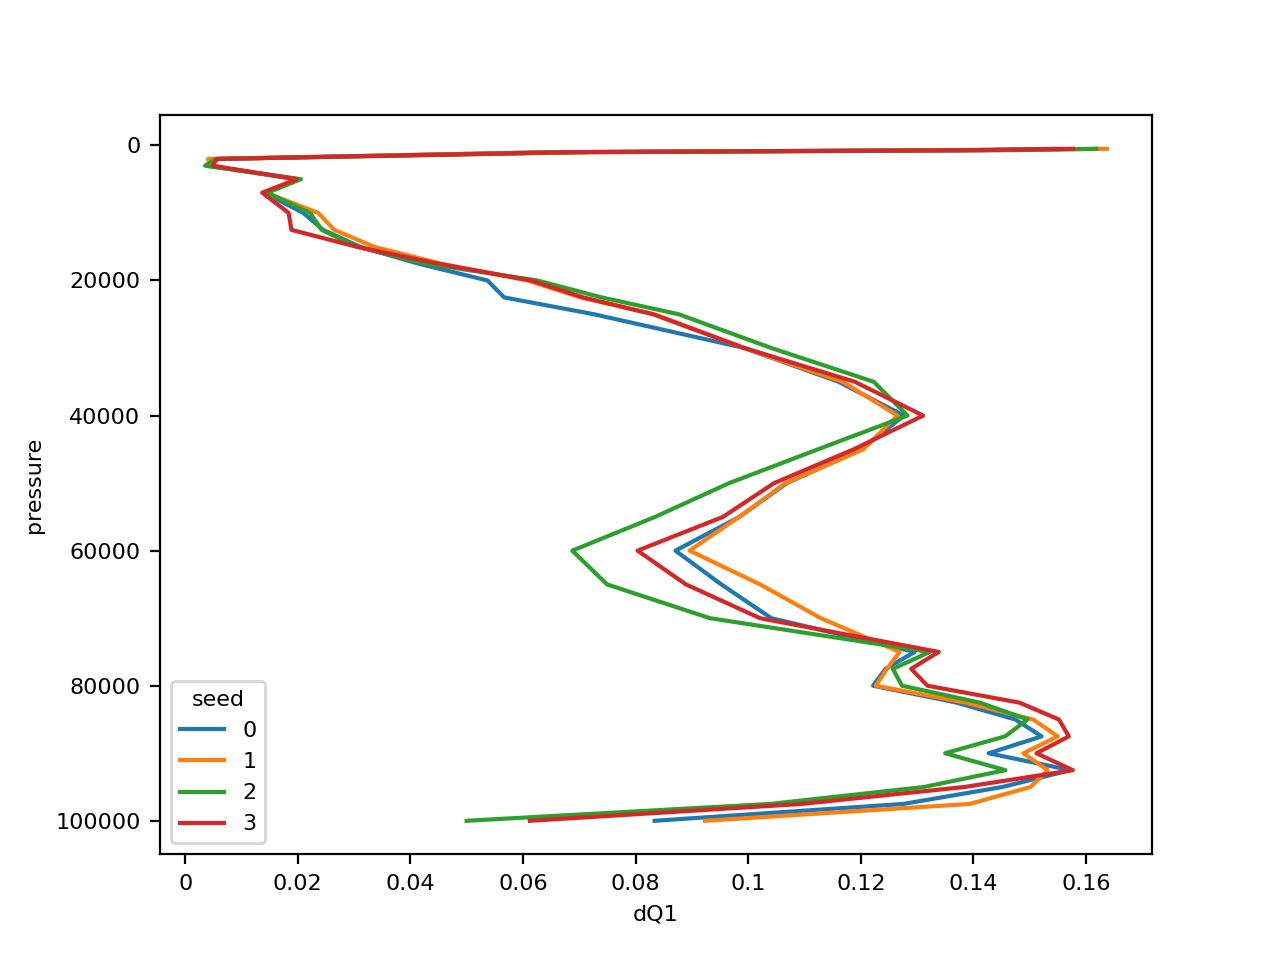

In [13]:
all_climate_r2.dQ1.plot(hue="seed", y="pressure", yincrease=False)

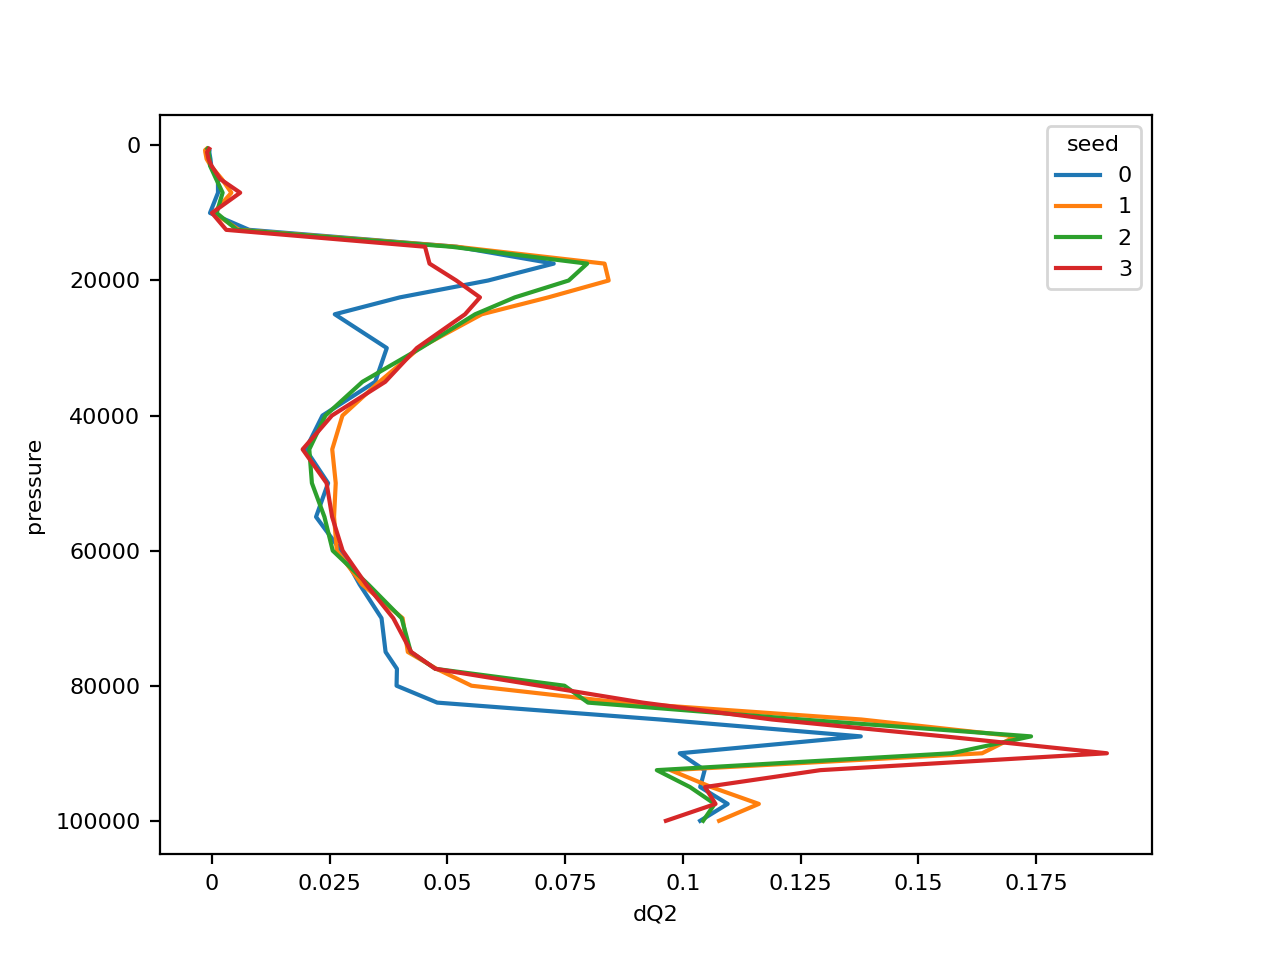

In [14]:
all_climate_r2.dQ2.plot(hue="seed", y="pressure", yincrease=False)

In [16]:
per_climate_r2.to_netcdf("per-climate-nudging-tendency-r2.nc")

In [17]:
all_climate_r2.to_netcdf("all-climate-nudging-tendency-r2.nc")

In [ ]:
vcm.catalog.catalog["wind_rotation/c48"].to_dask()
vcm.cubedsphere.center_and_rotate_xy_winds()

In [19]:
vcm.catalog.catalog.

AttributeError: list